In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/vito/.local/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from __future__ import annotations
from abc import ABC, abstractmethod, abstractproperty
from typing import Tuple

class NodeCollection():
    def __init__(self, application) -> None:
        self.nodes = {}
        self._application = application
        
    def add(self, node: Tuple[str, pd.DataFrame]) -> None:
        self.nodes[node[0]] = node[1]
    
    def plotbox(self, column: str, figsize: Tuple[int, int]=(5,10), logscale: str=None) -> None:
        data = {}
        v_vars = []
        for node in list(self.nodes.items()):
            data[node[0]+'_'+column] = node[1][column]
            v_vars.append(node[0]+'_'+column)
        df = pd.DataFrame(data)
        df_melt = df.melt(value_vars=v_vars, var_name='columns')
        plt.figure(figsize=figsize)
        b = sns.boxplot(data = df_melt,
                    hue = 'columns', # different colors for different 'columns'
                    x = 'columns',
                    y = 'value',
                    order = v_vars,
                   dodge=False)
        if(logscale != None):
            b.set(yscale=logscale)
        plt.title(self._application+': '+column)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        
    def plotmean(self, column: str, figsize: Tuple[int, int]=(10,5), logscale: str=None) -> None:
        index = []
        mean = []
        std = []
        for n in list(self.nodes.items()):
            index.append(n[0]+'_'+column)
            mean.append(n[1][column].mean())
            std.append(n[1][column].std())
        df_mean = pd.DataFrame(mean, index=index)
        df_std = pd.DataFrame(std, index=index)
        p = df_mean.plot(figsize=figsize,legend=False,kind="bar",rot=45,color="blue",fontsize=16,yerr=df_std, capsize=10);
        p.set_title(self._application + ':' + ' mean ' + column)
        if logscale != None:
            p.set_yscale(logscale)
        #plt.tight_layout()
        plt.show()

In [3]:
framesource = {
    'N1E2': pd.read_csv("backup2/mpp3r03c04s03.csv", header=0, index_col=0, parse_dates=True),
    'N1E3': pd.read_csv("backup2/mpp3r01c01s01.csv", header=0, index_col=0, parse_dates=True),
    'N1E4': pd.read_csv("backup2/mpp3r02c05s07.csv", header=0, index_col=0, parse_dates=True),
    'N1E1': pd.read_csv("backup_exp1_CSV/mpp3r02c05s02.csv", header=0, index_col=0, parse_dates=True),
    'N2E1': pd.read_csv("backup_exp1_CSV/mpp3r02c05s03.csv", header=0, index_col=0, parse_dates=True),
    'N3E1': pd.read_csv("backup_exp1_CSV/mpp3r02c05s05.csv", header=0, index_col=0, parse_dates=True),
    'N4E1': pd.read_csv("backup_exp1_CSV/mpp3r02c05s07.csv", header=0, index_col=0, parse_dates=True)
}

In [4]:
from typing import Dict

class Builder(ABC):
    @abstractproperty
    def product(self) -> None:
        pass
    @abstractmethod
    def produce_df(self, name: str) -> None:
        pass
    
class KrikpeBuilder(Builder):
    def __init__(self, datasource: Dict[str, pd.DataFrame]) -> None:
        self._datasource = datasource
        self.reset()
        
    def reset(self) -> None:
        self._kripkeCollection = NodeCollection('Kripke')
        
    @property
    def product(self) -> NodeCollection:
        collection = self._kripkeCollection
        self.reset()
        return collection
    
    def produce_df(self, name: str) -> None:
        self._kripkeCollection.add((name, self._datasource[name].loc[(self._datasource[name]['experiment/applicationLabel'] == 20) & (self._datasource[name]['faultLabel'] == 0)]))
    
class HplBuilder(Builder):
    def __init__(self, datasource: Dict[str, pd.DataFrame]) -> None:
        self._datasource = datasource
        self.reset()
        
    def reset(self) -> None:
        self._hplCollection = NodeCollection('HPL')
        
    @property
    def product(self) -> NodeCollection:
        collection = self._hplCollection
        self.reset()
        return collection
    
    def produce_df(self, name: str) -> None:
        self._hplCollection.add((name, self._datasource[name].loc[(self._datasource[name]['experiment/applicationLabel'] == 24) & (self._datasource[name]['faultLabel'] == 0)]))


In [7]:
import re
from typing import Iterator

class CpuKripkeBuilder(Builder):
    def __init__(self, datasource: Dict[str, pd.DataFrame]) -> None:
        self._datasource = datasource
        self.reset()
        
    def reset(self) -> None:
        #requires python 3.6+
        key = next(iter(self._datasource)) #retrieve key of first element in datasource dictionary
        self.setCpuMetricsAttribute(self._datasource[key].columns)
        self._cpuKripkeCollection = NodeCollection('Kripke')
        
    @property
    def product(self) -> NodeCollection:
        collection = self._cpuKripkeCollection
        self.reset()
        return collection
    
    def setCpuMetricsAttribute(self, columns: Iterator[str]) -> None:
        self._lst = []
        regex = re.compile('cpu[0-9]+\/')
        #get columns in the form "cpuXX/<metricname>"
        cpucols = [col for col in columns if regex.match(col)]
        #get only the <metricname> in "cpuXX/<metricname>", there will be duplicates
        dupcpuatt = [re.sub(r"cpu[0-9]+\/", "", col) for col in cpucols]
        #remove duplicates by using a set
        cpuatt_set = set(dupcpuatt)
        #convert again to list and assign to lst
        self._lst.extend(list(cpuatt_set))
        
    def computeCpuSpecificMetrics(self, df: pd.DataFrame) -> pd.DataFrame:
        ndf = pd.DataFrame()
        for m in self._lst:
            regex = re.compile("cpu[0-9]+\/" + m)
            selected_columns = [col for col in df.columns if regex.match(col)]
            ndf["min_cpus/" + m] = df[selected_columns].min(axis=1)
            ndf["max_cpus/" + m] = df[selected_columns].max(axis=1)
            ndf["perc25_cpus/" + m] = df[selected_columns].quantile(q=0.25, axis=1)
            ndf["perc75_cpus/" + m] = df[selected_columns].quantile(q=0.75, axis=1)
            ndf["mean_cpus/" + m] = df[selected_columns].mean(axis=1)
        return ndf
    
    def produce_df(self, name: str) -> None:
        self._cpuKripkeCollection.add((name, self.computeCpuSpecificMetrics(self._datasource[name].loc[(self._datasource[name]['experiment/applicationLabel'] == 20) & (self._datasource[name]['faultLabel'] == 0)])))
            
        
class CpuHplBuilder(Builder):
    def __init__(self, datasource: Dict[str, pd.DataFrame]) -> None:
        self._datasource = datasource
        self.reset()
        
    def reset(self) -> None:
        #requires python 3.6+
        key = next(iter(self._datasource)) #retrieve key of first element in datasource dictionary
        self.setCpuMetricsAttribute(self._datasource[key].columns)
        self._cpuHplCollection = NodeCollection('HPL')
        
    @property
    def product(self) -> NodeCollection:
        collection = self._cpuHplCollection
        self.reset()
        return collection
    
    def setCpuMetricsAttribute(self, columns: Iterator[str]) -> None:
        self._lst = []
        regex = re.compile('cpu[0-9]+\/')
        #get columns in the form "cpuXX/<metricname>"
        cpucols = [col for col in columns if regex.match(col)]
        #get only the <metricname> in "cpuXX/<metricname>", there will be duplicates
        dupcpuatt = [re.sub(r"cpu[0-9]+\/", "", col) for col in cpucols]
        #remove duplicates by using a set
        cpuatt_set = set(dupcpuatt)
        #convert again to list and assign to lst
        self._lst.extend(list(cpuatt_set))
        
    def computeCpuSpecificMetrics(self, df: pd.DataFrame) -> pd.DataFrame:
        ndf = pd.DataFrame()
        for m in self._lst:
            regex = re.compile("cpu[0-9]+\/" + m)
            selected_columns = [col for col in df.columns if regex.match(col)]
            ndf["min_cpus/" + m] = df[selected_columns].min(axis=1)
            ndf["max_cpus/" + m] = df[selected_columns].max(axis=1)
            ndf["perc25_cpus/" + m] = df[selected_columns].quantile(q=0.25, axis=1)
            ndf["perc75_cpus/" + m] = df[selected_columns].quantile(q=0.75, axis=1)
            ndf["mean_cpus/" + m] = df[selected_columns].mean(axis=1)
        return ndf
    
    def produce_df(self, name: str) -> None:
        self._cpuHplCollection.add((name, self.computeCpuSpecificMetrics(self._datasource[name].loc[(self._datasource[name]['experiment/applicationLabel'] == 24) & (self._datasource[name]['faultLabel'] == 0)])))
          

In [8]:
kripkeBuilder = KrikpeBuilder(framesource)
hplBuilder = HplBuilder(framesource)
cpuKripkeBuilder = CpuKripkeBuilder(framesource)
cpuHplBuilder = CpuHplBuilder(framesource)

In [9]:
kripkeBuilder.produce_df('N1E2')
kripkeBuilder.produce_df('N1E3')
kripkeBuilder.produce_df('N1E4')
kripkeBuilder.produce_df('N1E1')
kripkeBuilder.produce_df('N2E1')
kripkeBuilder.produce_df('N3E1')
kripkeBuilder.produce_df('N4E1')

kripkeCollection = kripkeBuilder.product

In [10]:
hplBuilder.produce_df('N1E2')
hplBuilder.produce_df('N1E3')
hplBuilder.produce_df('N1E4')
hplBuilder.produce_df('N1E1')
hplBuilder.produce_df('N2E1')
hplBuilder.produce_df('N3E1')
hplBuilder.produce_df('N4E1')

hplCollection = hplBuilder.product

In [11]:
cpuKripkeBuilder.produce_df('N1E2')
cpuKripkeBuilder.produce_df('N1E3')
cpuKripkeBuilder.produce_df('N1E4')
cpuKripkeBuilder.produce_df('N1E1')
cpuKripkeBuilder.produce_df('N2E1')
cpuKripkeBuilder.produce_df('N3E1')
cpuKripkeBuilder.produce_df('N4E1')

cpuKripkeCollection = cpuKripkeBuilder.product

In [12]:
cpuHplBuilder.produce_df('N1E2')
cpuHplBuilder.produce_df('N1E3')
cpuHplBuilder.produce_df('N1E4')
cpuHplBuilder.produce_df('N1E1')
cpuHplBuilder.produce_df('N2E1')
cpuHplBuilder.produce_df('N3E1')
cpuHplBuilder.produce_df('N4E1')

cpuHplCollection = cpuHplBuilder.product

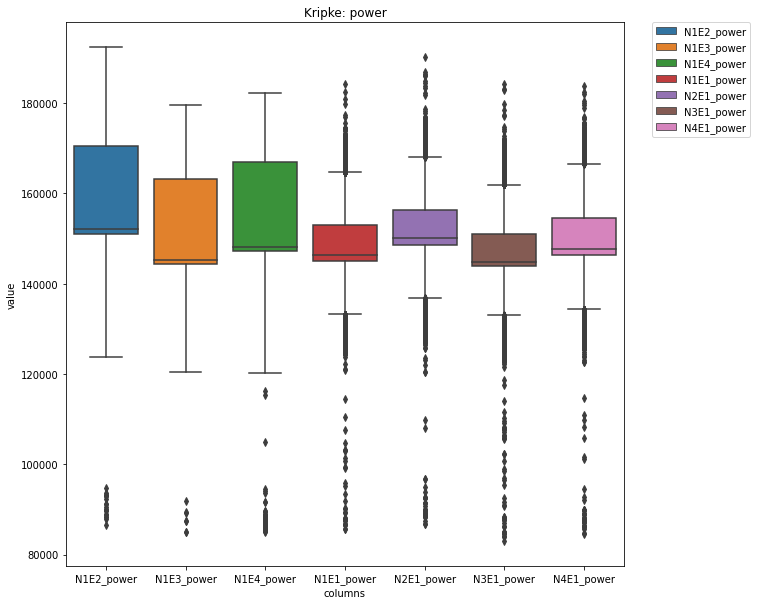

In [13]:
kripkeCollection.plotbox('power', figsize=(10,10))

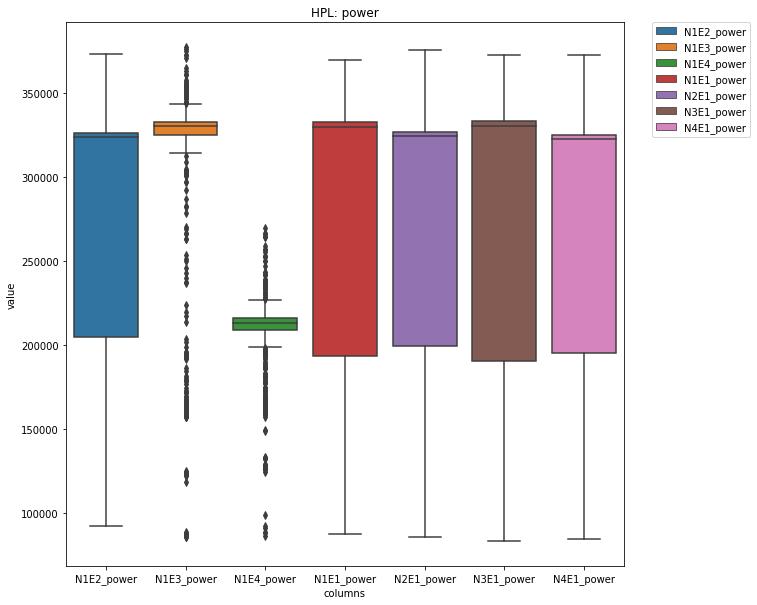

In [14]:
hplCollection.plotbox('power', figsize=(10,10))

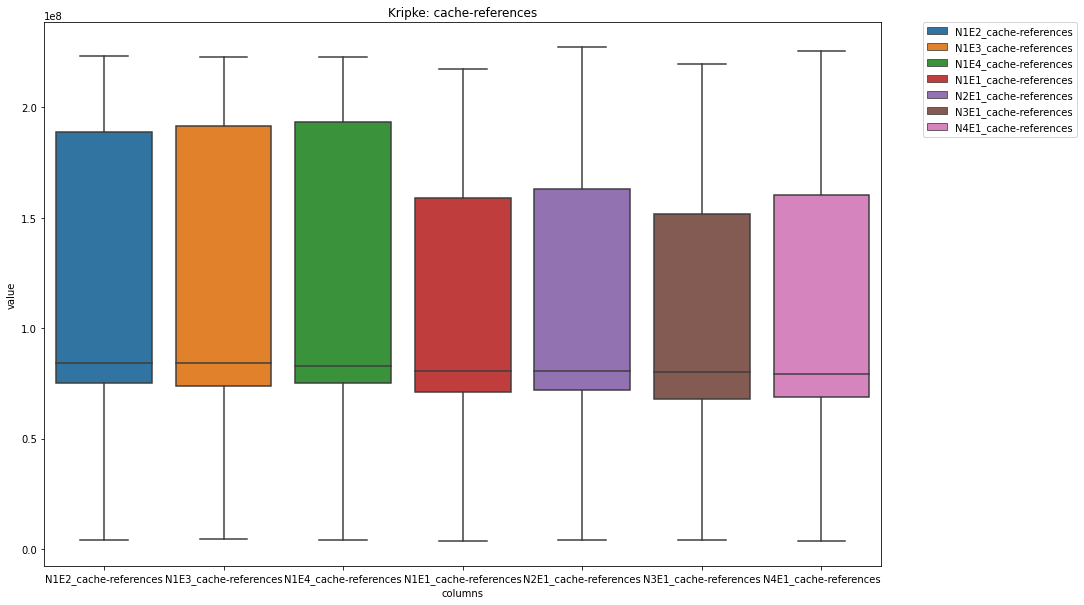

In [15]:
kripkeCollection.plotbox('cache-references', figsize=(15,10))

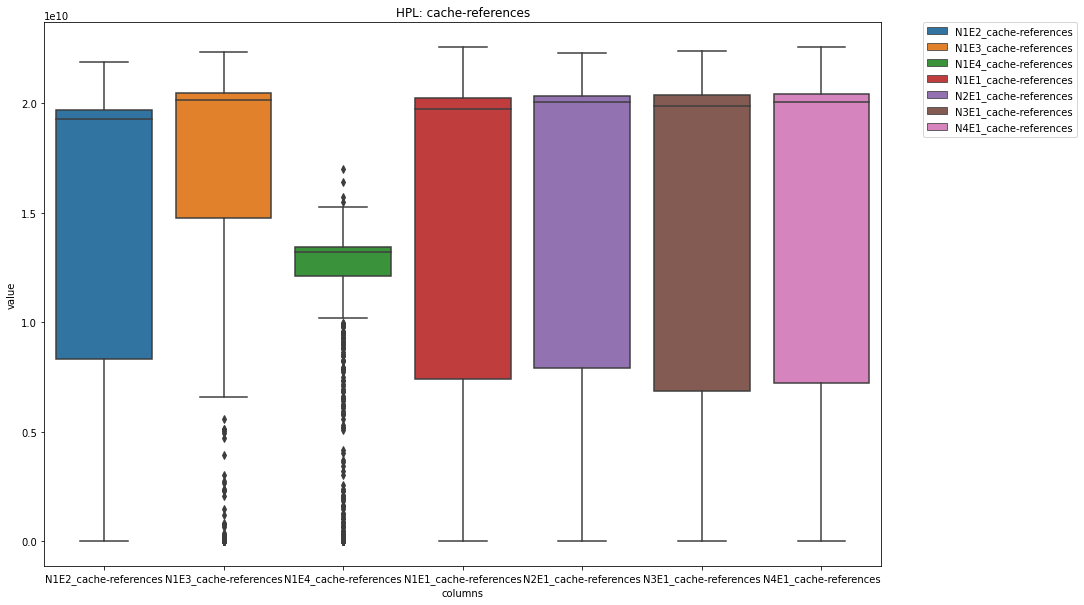

In [16]:
hplCollection.plotbox('cache-references', figsize=(15,10))

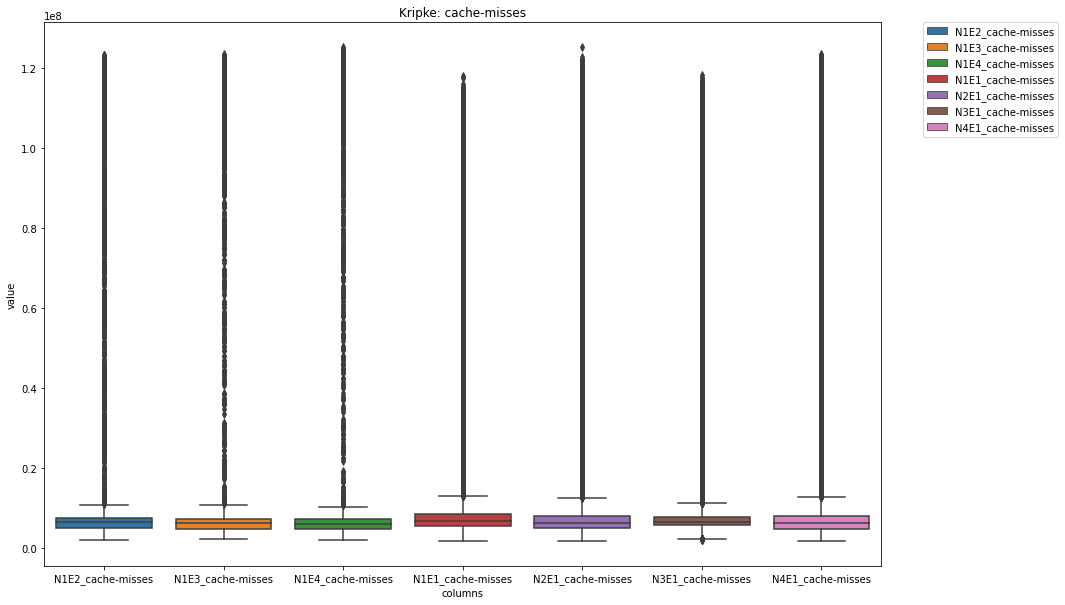

In [17]:
kripkeCollection.plotbox('cache-misses', figsize=(15,10))

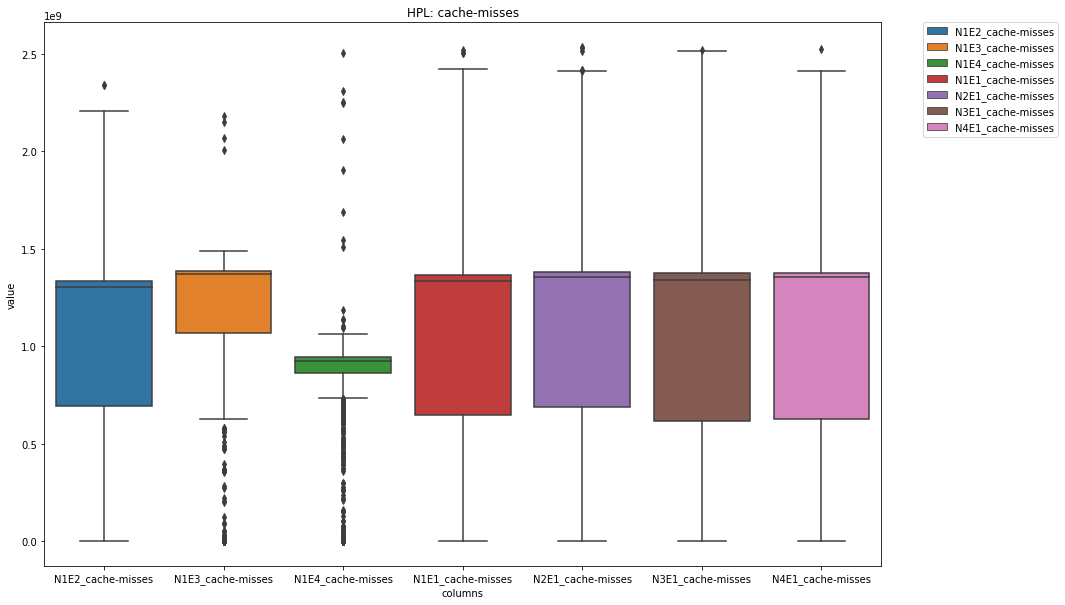

In [18]:
hplCollection.plotbox('cache-misses', figsize=(15,10))

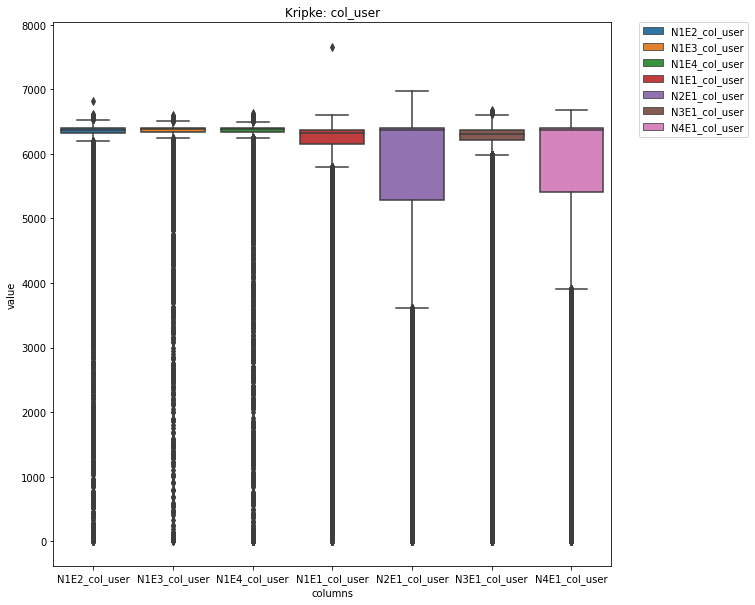

In [19]:
kripkeCollection.plotbox('col_user', figsize=(10,10))

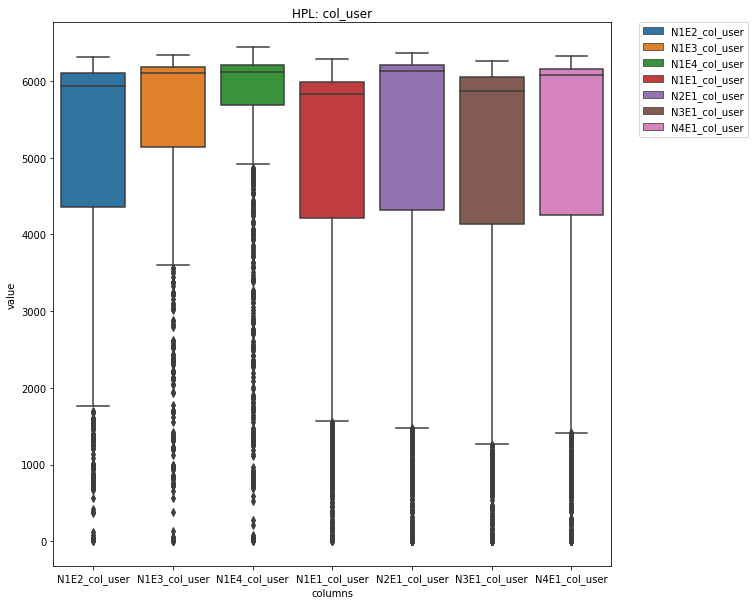

In [20]:
hplCollection.plotbox('col_user', figsize=(10,10))

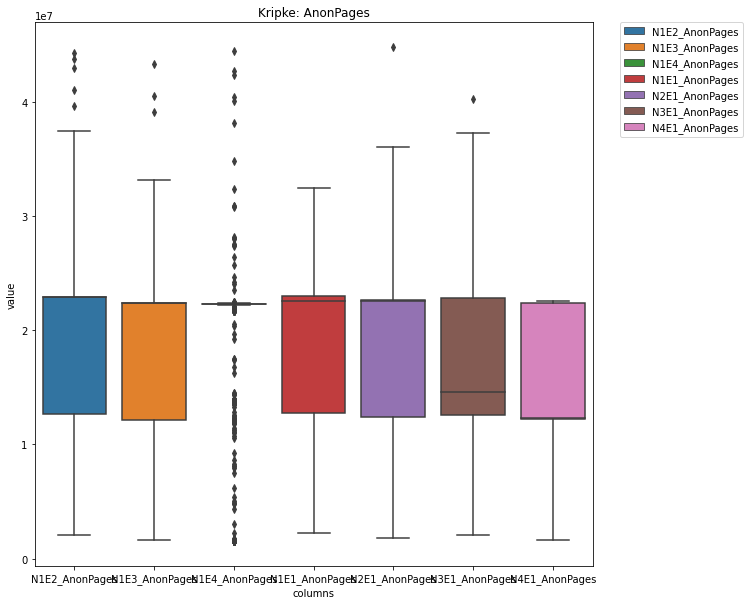

In [21]:
kripkeCollection.plotbox('AnonPages', figsize=(10,10))

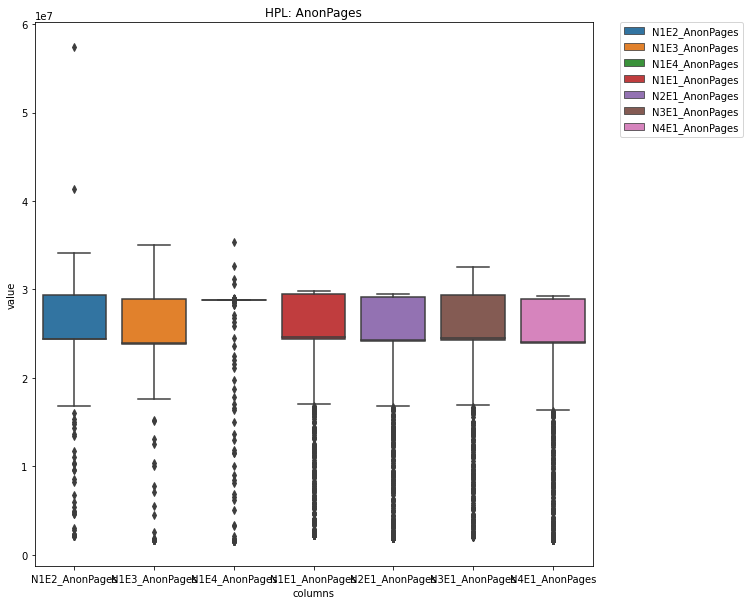

In [22]:
hplCollection.plotbox('AnonPages', figsize=(10,10))

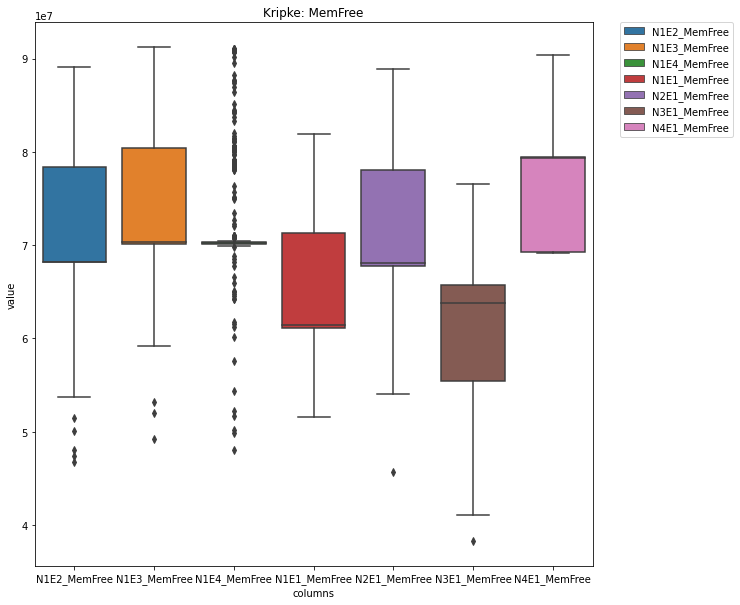

In [23]:
kripkeCollection.plotbox('MemFree', figsize=(10,10))

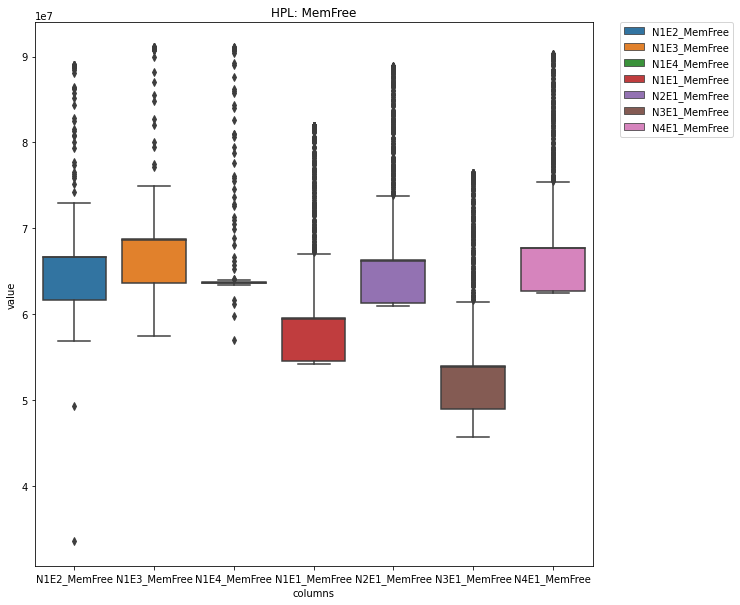

In [24]:
hplCollection.plotbox('MemFree', figsize=(10,10))

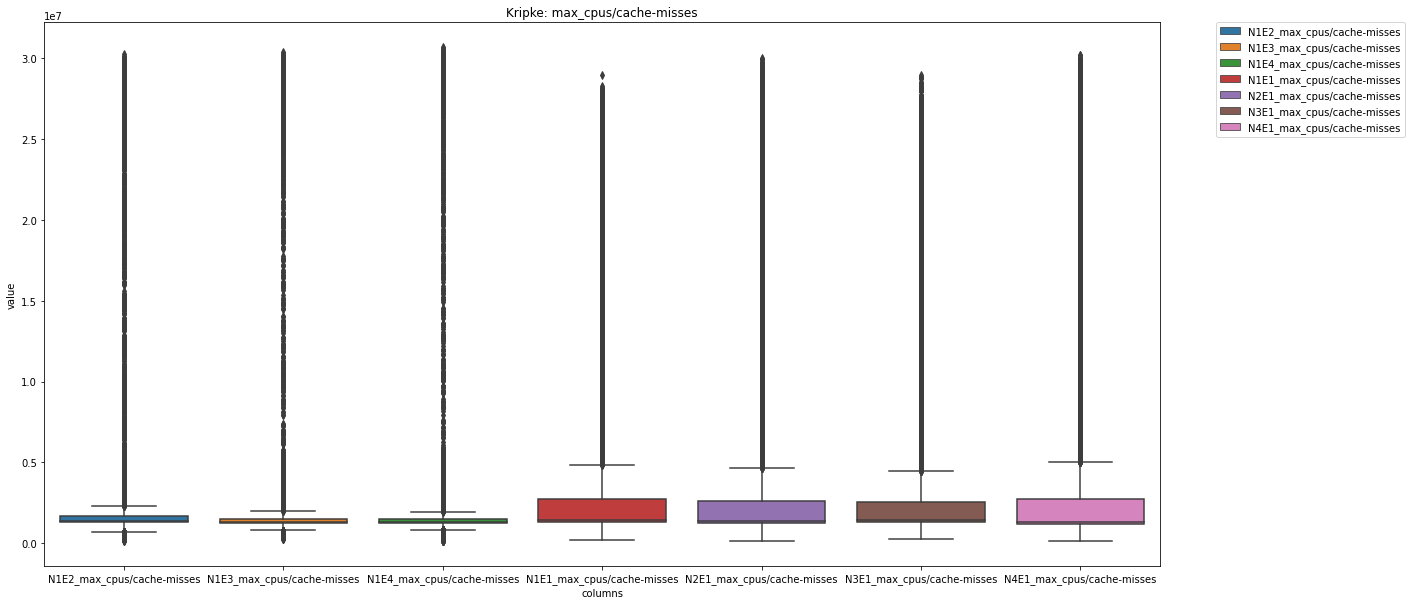

In [25]:
cpuKripkeCollection.plotbox('max_cpus/cache-misses', figsize=(20,10))

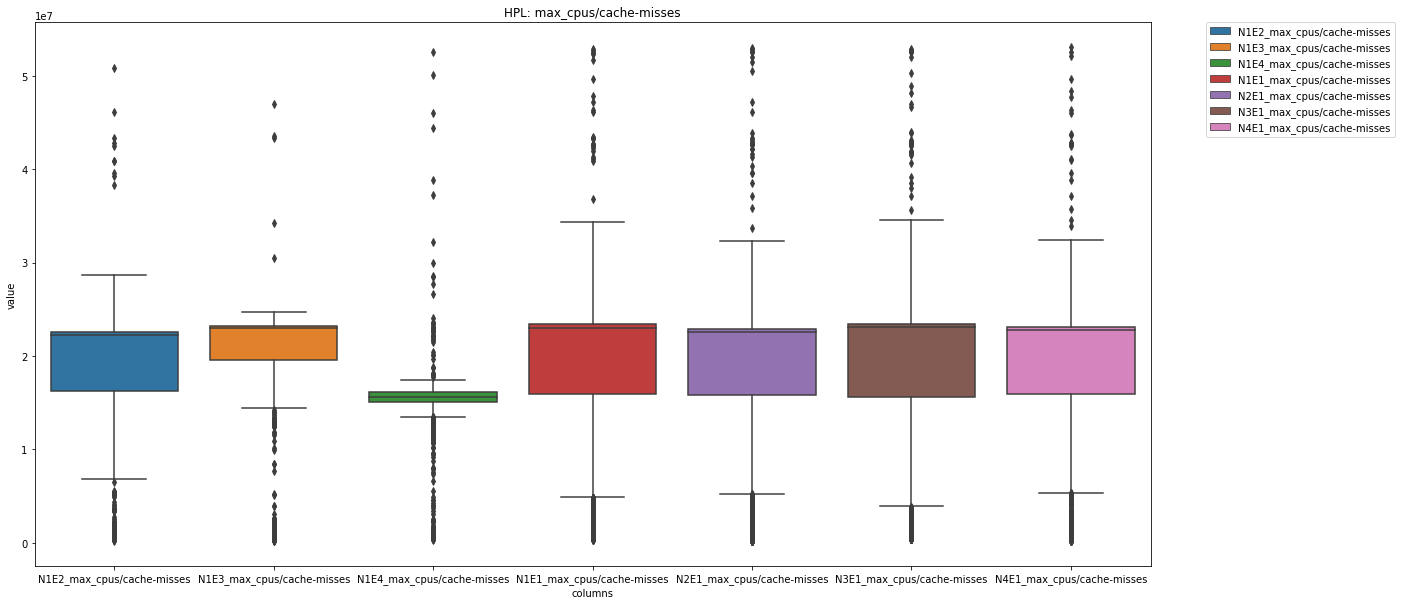

In [26]:
cpuHplCollection.plotbox('max_cpus/cache-misses', figsize=(20,10))

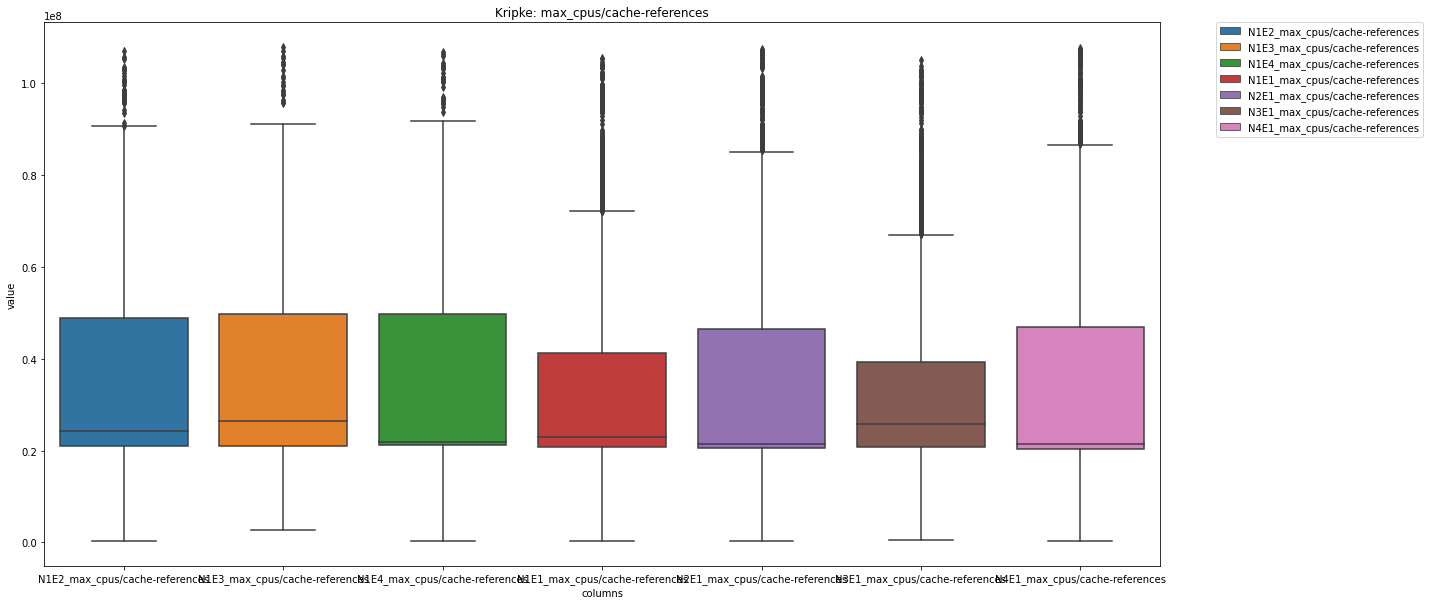

In [27]:
cpuKripkeCollection.plotbox('max_cpus/cache-references', figsize=(20,10))

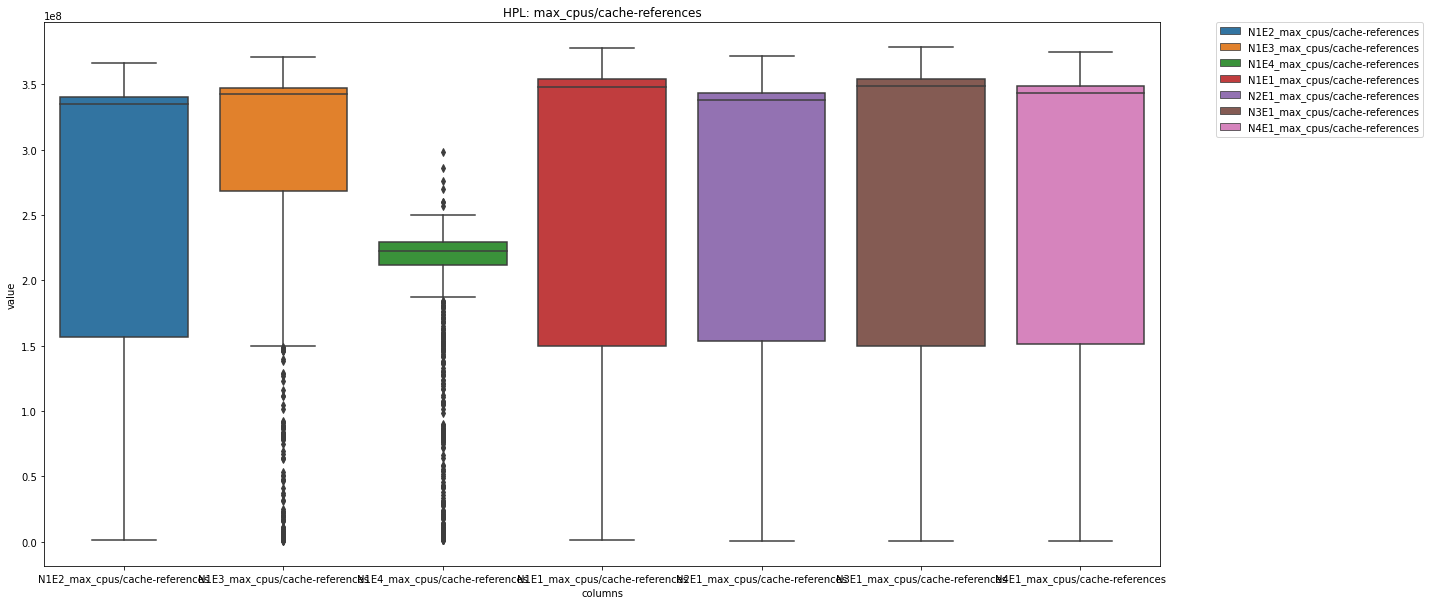

In [28]:
cpuHplCollection.plotbox('max_cpus/cache-references', figsize=(20,10))

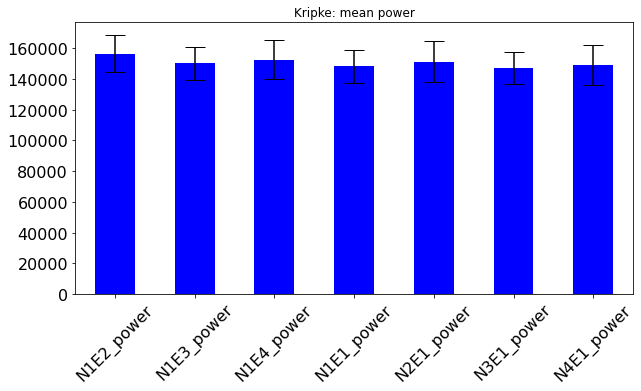

In [29]:
kripkeCollection.plotmean('power')

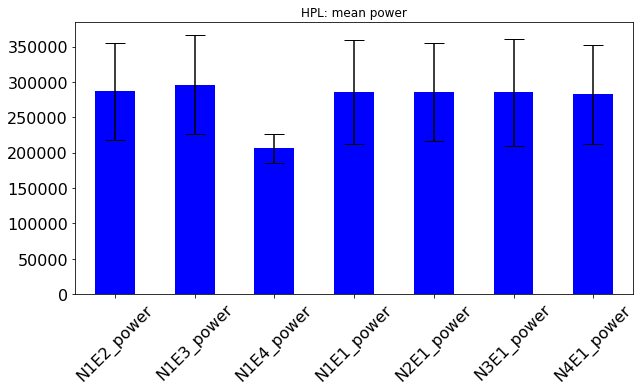

In [30]:
hplCollection.plotmean('power')

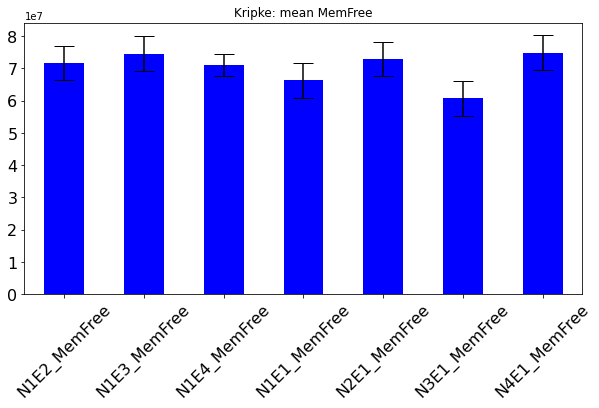

In [31]:
kripkeCollection.plotmean('MemFree')

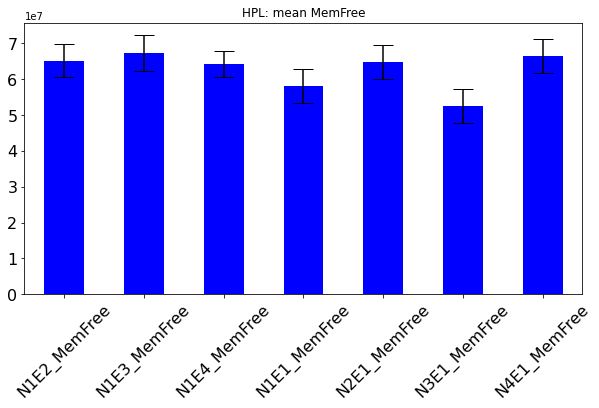

In [32]:
hplCollection.plotmean('MemFree')

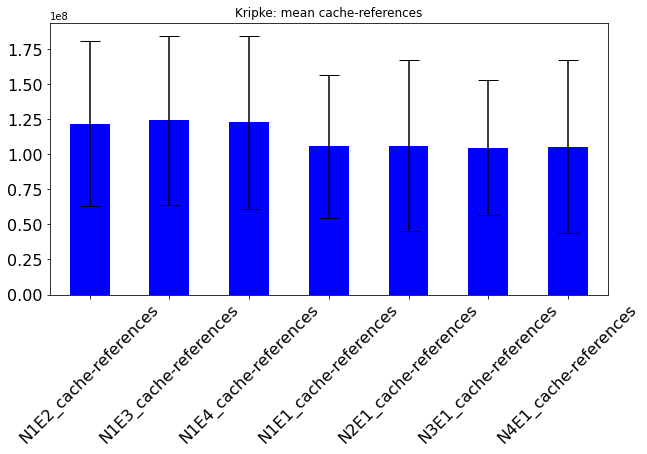

In [33]:
kripkeCollection.plotmean('cache-references')

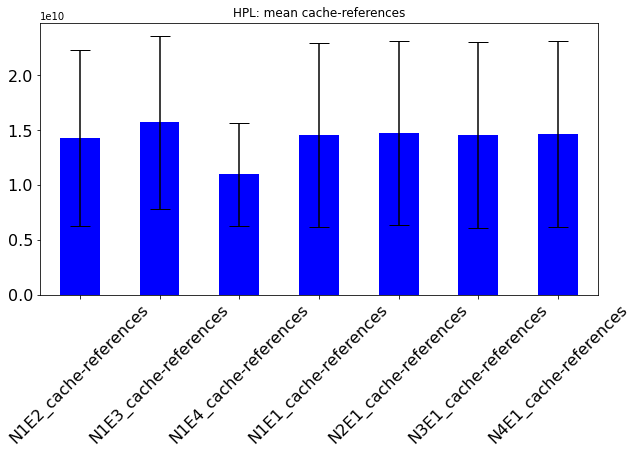

In [34]:
hplCollection.plotmean('cache-references')

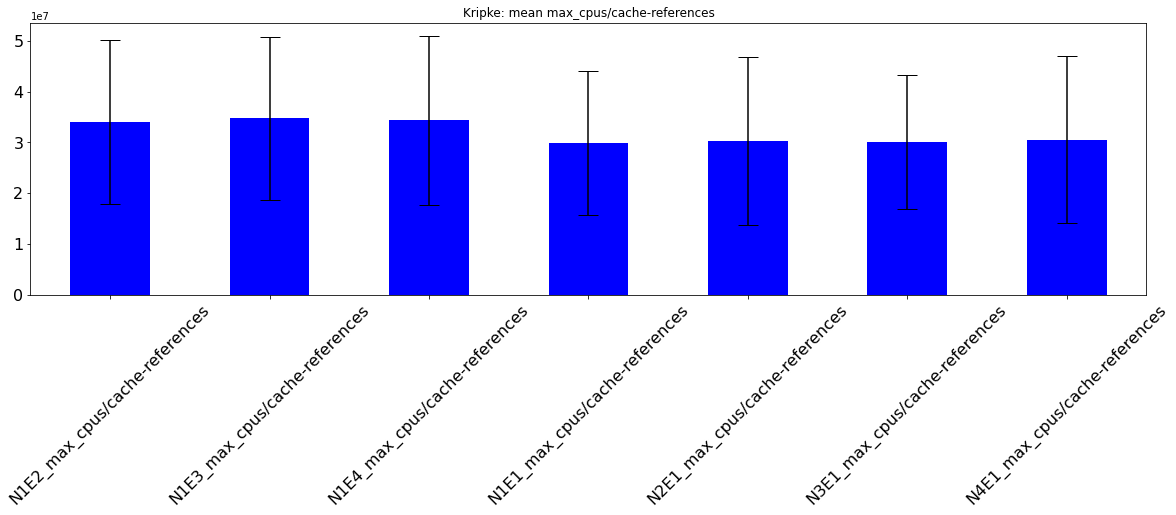

In [35]:
cpuKripkeCollection.plotmean('max_cpus/cache-references', figsize=(20,5))

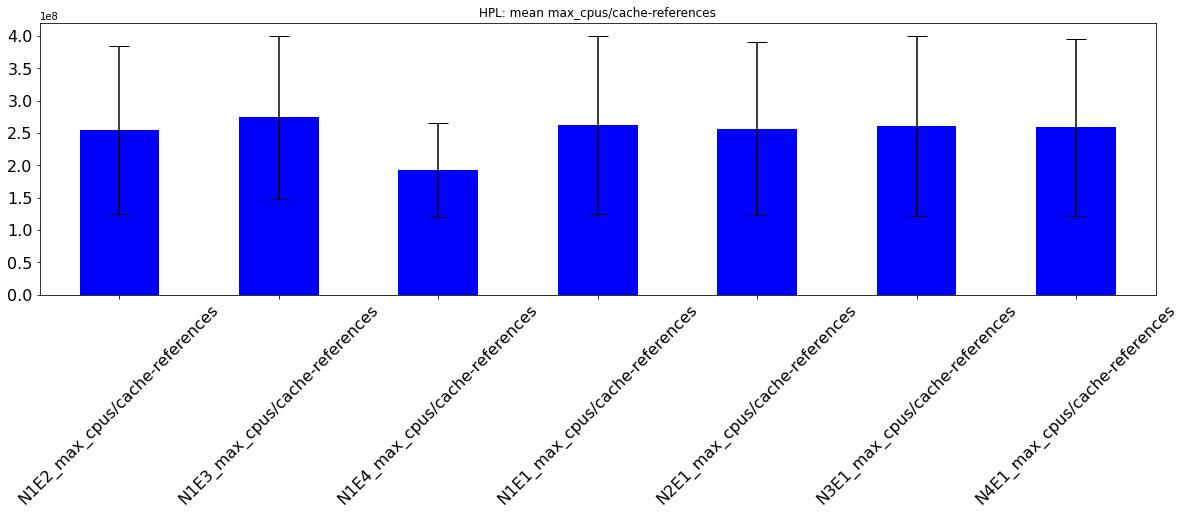

In [36]:
cpuHplCollection.plotmean('max_cpus/cache-references', figsize=(20,5))

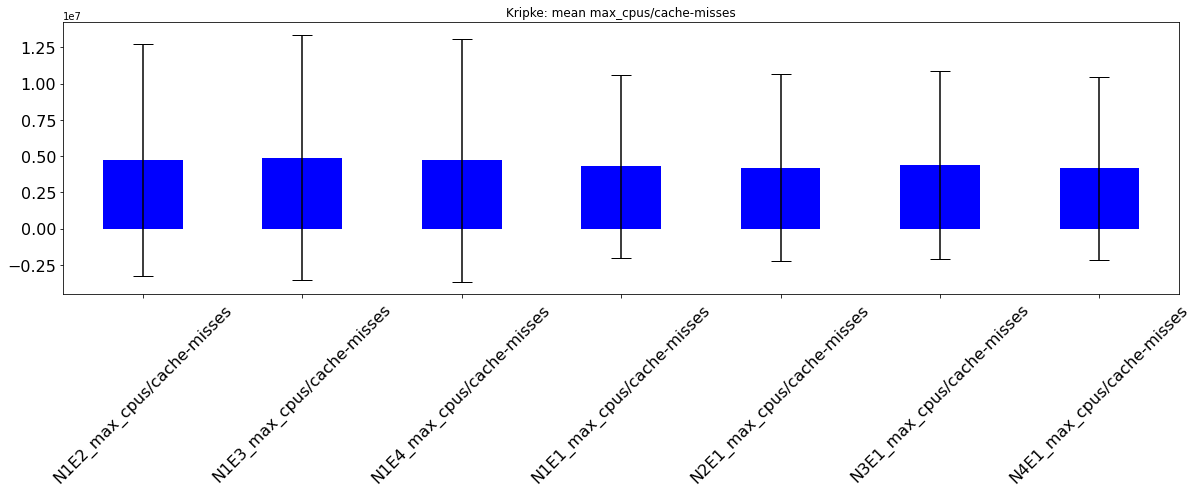

In [37]:
cpuKripkeCollection.plotmean('max_cpus/cache-misses', figsize=(20,5))

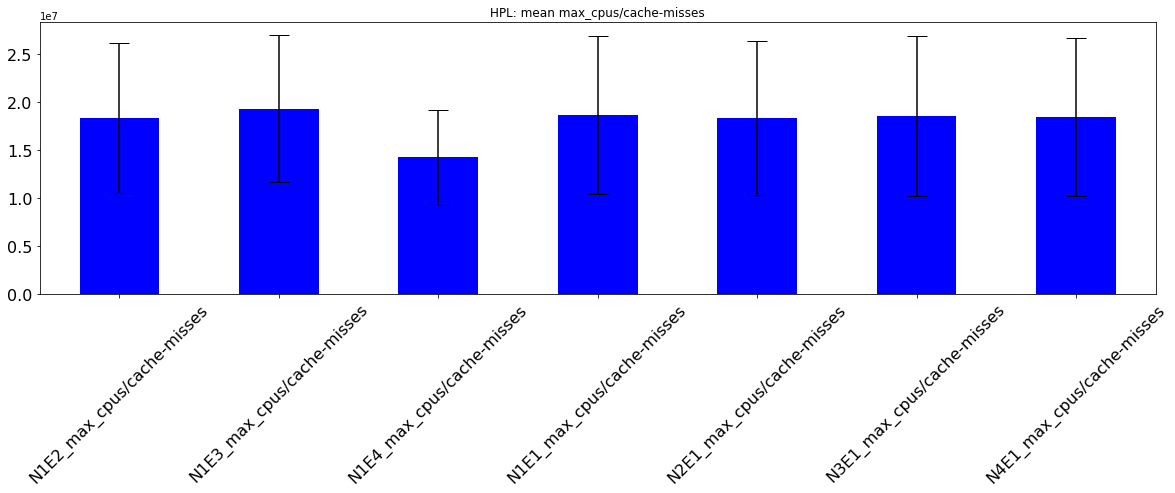

In [38]:
cpuHplCollection.plotmean('max_cpus/cache-misses', figsize=(20,5))